In [65]:
!gdown https://drive.google.com/uc?id=1sekoYqTeHOjVgzLSyl0087d4RggdW0Q5

Downloading...
From: https://drive.google.com/uc?id=1sekoYqTeHOjVgzLSyl0087d4RggdW0Q5
To: /content/Metro_Interstate_Traffic_Volume.csv
100% 3.24M/3.24M [00:00<00:00, 173MB/s]


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [68]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [69]:

########
num_of_feature = 8 # number of input features for the TCN network
past_observation = 6 # Number of past hours data used as input to the TCN network
##########





# Read dataset

In [70]:
# Import Dataset
traffic_data = pd.read_csv("/content/drive/My Drive/Metro_Interstate_Traffic_Volume.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['date_time'])).rename(columns={"date_time": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

<ipython-input-70-46ccfd7a0484>:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)


In [71]:
traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


In [72]:
traffic_data = traffic_data.drop_duplicates()

In [73]:
# Checking for any missing or empty value
traffic_data.isna().sum()

holiday                48126
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
ds                         0
traffic_volume             0
dtype: int64

# convert categorical to nominal data

In [74]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
traffic_data['weather_description'] = label_encoder.fit_transform(traffic_data['weather_description'])

<ipython-input-74-2df862e316d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
<ipython-input-74-2df862e316d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
<ipython-input-74-2df862e316d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [75]:
traffic_data.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
count,48187.0,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187,48187.000000
mean,1.0,281.204995,0.334382,0.000222,49.365451,2.578642,16.540021,2016-01-05 06:49:48.133729024,3259.618134
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,1.0,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,2014-02-06 07:30:00,1192.500000
50%,1.0,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,2016-06-10 21:00:00,3379.000000
75%,1.0,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,2017-08-11 05:30:00,4933.000000
max,1.0,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,2018-09-30 23:00:00,7280.000000
std,0.0,13.338738,44.797033,0.008169,39.015213,2.784148,8.969561,NaN,1986.954465


<Axes: xlabel='date_time'>

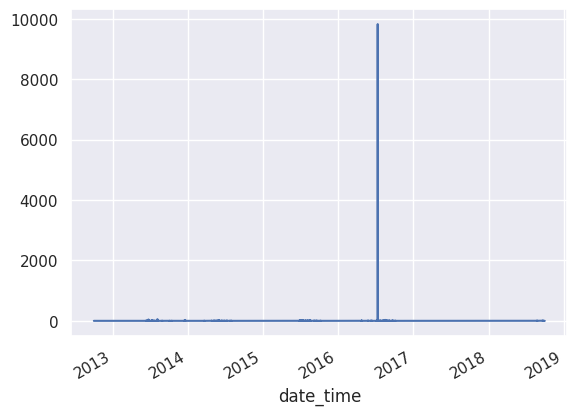

In [76]:
#traffic_data['temp'].plot()
traffic_data['rain_1h'].plot()


<Axes: xlabel='date_time'>

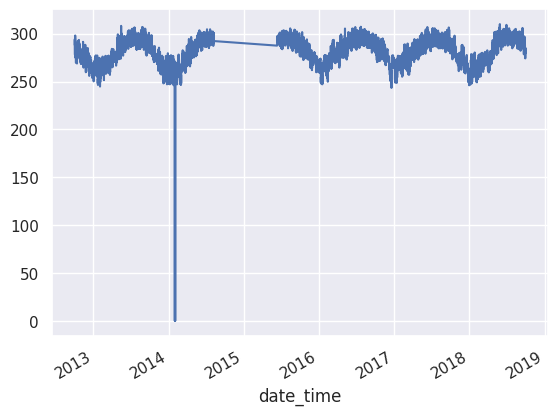

In [77]:
traffic_data['temp'].plot()

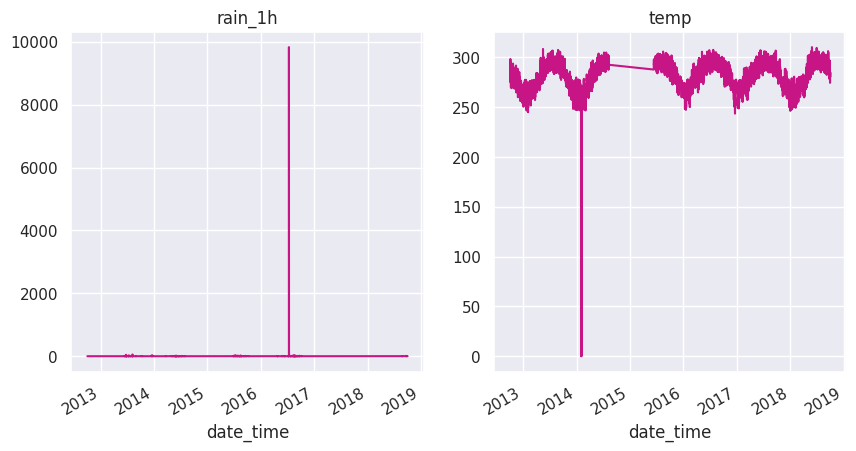

In [78]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("with_outlier.png", dpi=600)

In [79]:
Q1 = traffic_data.quantile(0.25)
Q3 = traffic_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

holiday                               0.0
temp                               19.646
rain_1h                               0.0
snow_1h                               0.0
clouds_all                           89.0
weather_main                          5.0
weather_description                  17.0
ds                     1281 days 22:00:00
traffic_volume                     3740.5
dtype: object


In [80]:
traffic_data=traffic_data[~((traffic_data['temp'] <(Q1['temp']-1.5*IQR['temp'])) | (traffic_data['temp'] >(Q1['temp']+1.5*IQR['temp'])))]
traffic_data=traffic_data[~((traffic_data['traffic_volume'] <(Q1['traffic_volume']-1.5*IQR['traffic_volume'])) | (traffic_data['traffic_volume'] >(Q1['traffic_volume']+1.5*IQR['traffic_volume'])))]

# Prepare training and testing data

<Axes: xlabel='date_time'>

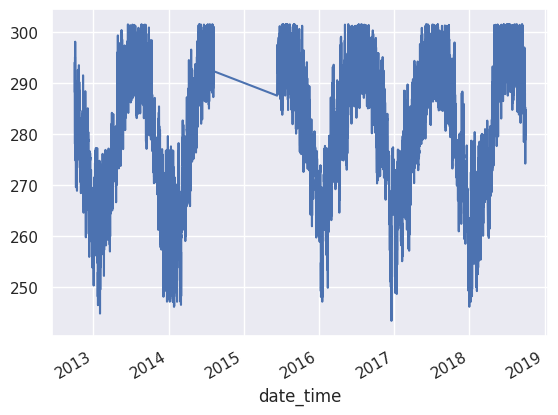

In [81]:
# ploting traffic data to see to see any data imbalance
traffic_data['temp'].plot()

<Axes: xlabel='date_time'>

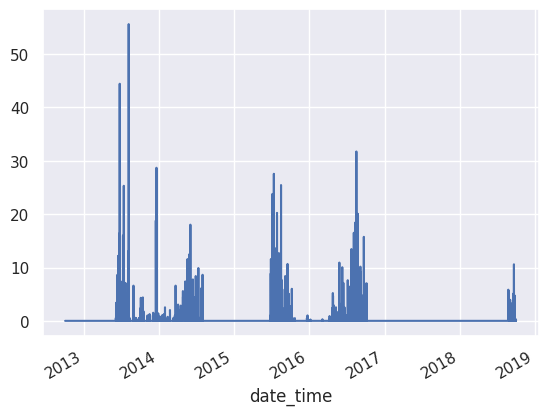

In [82]:
traffic_data['rain_1h'].plot()

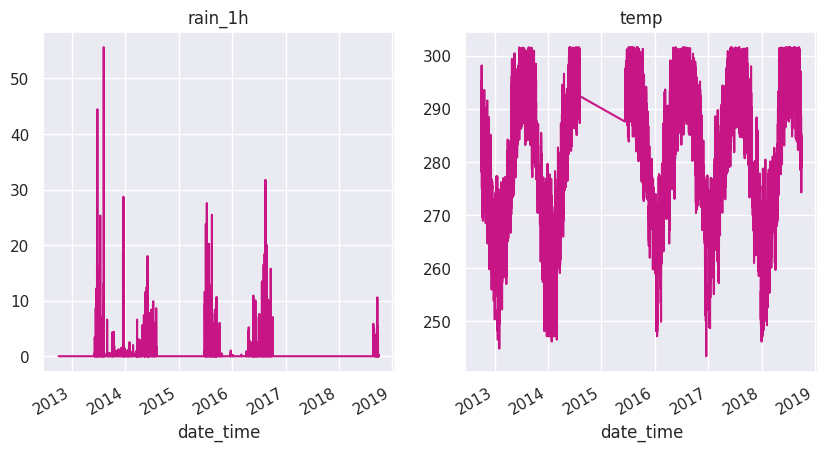

In [83]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("without_outlier.png", dpi=600)

In [84]:

traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,1,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,1,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,1,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,1,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,1,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,1,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [85]:
split_date = '2018-01-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

In [86]:
test_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-01-01 01:00:00,1,249.08,0.0,0.0,1,0,27,2018-01-01 01:00:00,1408
2018-01-01 02:00:00,1,248.86,0.0,0.0,1,0,27,2018-01-01 02:00:00,931
2018-01-01 03:00:00,1,248.72,0.0,0.0,1,0,27,2018-01-01 03:00:00,585
2018-01-01 04:00:00,1,248.43,0.0,0.0,1,0,27,2018-01-01 04:00:00,381
2018-01-01 05:00:00,1,248.07,0.0,0.0,1,0,27,2018-01-01 05:00:00,434
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,1,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,1,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [87]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

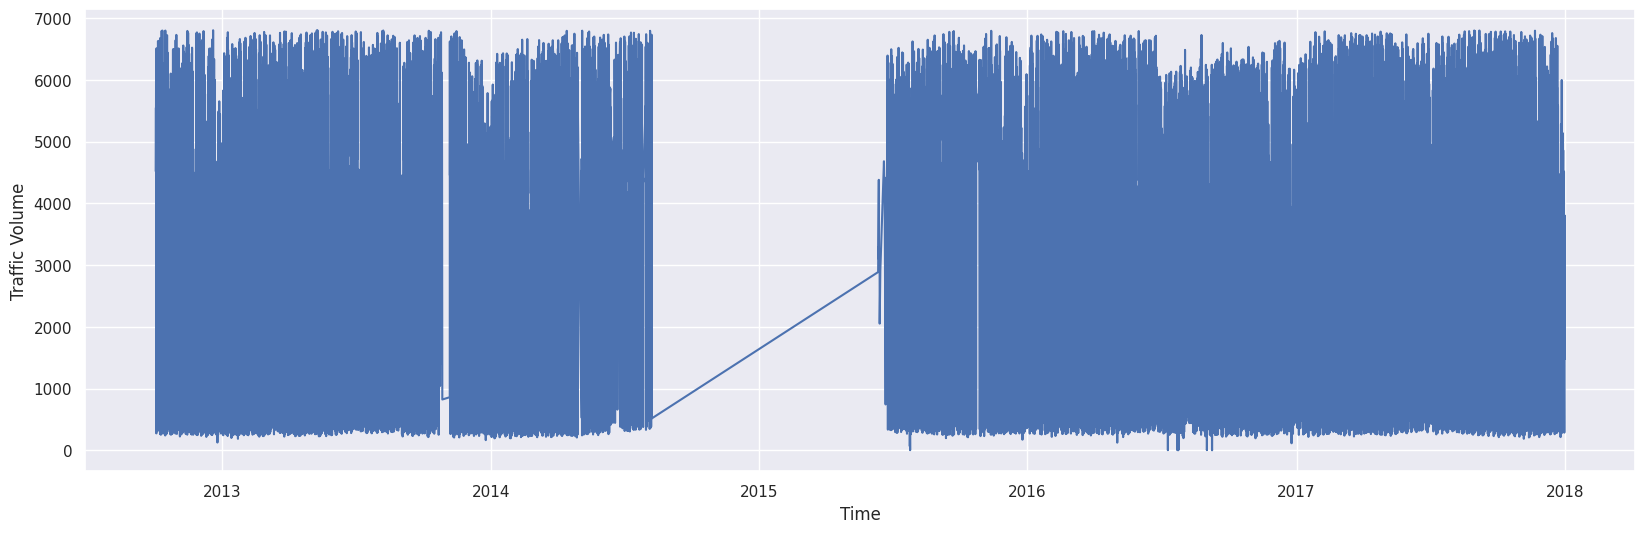

In [88]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)

In [89]:
train_data_without_ds = train_data.drop(columns=['ds'])
train_data_without_ds


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,1,288.28,0.0,0.0,40,1,24,5545
2012-10-02 10:00:00,1,289.36,0.0,0.0,75,1,2,4516
2012-10-02 11:00:00,1,289.58,0.0,0.0,90,1,19,4767
2012-10-02 12:00:00,1,290.13,0.0,0.0,90,1,19,5026
2012-10-02 13:00:00,1,291.14,0.0,0.0,75,1,2,4918
...,...,...,...,...,...,...,...,...
2017-12-31 20:00:00,1,249.79,0.0,0.0,5,0,27,2731
2017-12-31 21:00:00,1,249.61,0.0,0.0,5,0,27,2483
2017-12-31 22:00:00,1,249.50,0.0,0.0,1,0,27,2041


In [90]:
test_data_without_ds = test_data.drop(columns=['ds'])
test_data_without_ds

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2018-01-01 01:00:00,1,249.08,0.0,0.0,1,0,27,1408
2018-01-01 02:00:00,1,248.86,0.0,0.0,1,0,27,931
2018-01-01 03:00:00,1,248.72,0.0,0.0,1,0,27,585
2018-01-01 04:00:00,1,248.43,0.0,0.0,1,0,27,381
2018-01-01 05:00:00,1,248.07,0.0,0.0,1,0,27,434
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,1,283.45,0.0,0.0,75,1,2,3543
2018-09-30 20:00:00,1,282.76,0.0,0.0,90,1,19,2781
2018-09-30 21:00:00,1,282.73,0.0,0.0,90,10,21,2159


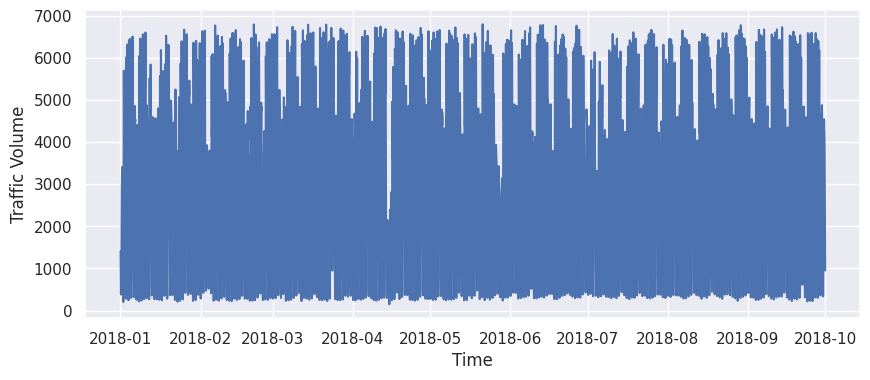

In [91]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(10,4))
plot_series(time_valid, x_valid)

In [92]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data_without_ds)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data_without_ds)
test_data_frame = pd.DataFrame(test_data_set)


In [93]:
# Make data for the TCN model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((39374, 6, 8), (39374,))

In [94]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((7622, 6, 8), (7622,))

In [95]:
# split data into train test and validation datase
from cgi import test

train_length = int(len(X)*0.9) # 80% trainging
validation_length = int(len(X)*.10) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

35436 3937 39373


In [96]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((35436, 6, 8), (35436,)), ((3938, 6, 8), (3938,)))

In [97]:
import inspect
from typing import List # noqa
import tensorflow as tf
# pylint: disable=E0611,E0401
from tensorflow.keras import backend as K, Model, Input, optimizers
# pylint: disable=E0611,E0401
from tensorflow.keras import layers
# pylint: disable=E0611,E0401
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
# pylint: disable=E0611,E0401
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization

def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)

def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations

class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):  # dilated conv block.
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                with K.name_scope('act_and_dropout_{}'.format(k)):
                    self._build_layer(Activation(self.activation, name='Act_Conv1D_{}'.format(k)))
                    self._build_layer(SpatialDropout1D(rate=self.dropout_rate, name='SDropout_{}'.format(k)))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape.
                    # 1x1 conv.
                    self.shape_match_conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=1,
                        padding='same',
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation, name='Act_Conv_Blocks'))
            self.final_activation = Activation(self.activation, name='Act_Res_Block')
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None, **kwargs):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        # https://arxiv.org/pdf/1803.01271.pdf  page 4, Figure 1 (b).
        # x1: Dilated Conv -> Norm -> Dropout (x2).
        # x2: Residual (1x1 matching conv - optional).
        # Output: x1 + x2.
        # x1 -> connected to skip connections.
        # x1 + x2 -> connected to the next block.
        #       input
        #     x1      x2
        #   conv1D    1x1 Conv1D (optional)
        #    ...
        #   conv1D
        #    ...
        #       x1 + x2
        x1 = inputs
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x1 = layer(x1, training=training) if training_flag else layer(x1)
        x2 = self.shape_match_conv(inputs)
        x1_x2 = self.final_activation(layers.add([x2, x1], name='Add_Res'))
        return [x1_x2, x1]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]

class TCN(Layer):
    """Creates a TCN layer.

        Input shape:
            A 3D tensor with shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            go_backwards: Boolean (default False). If True, process the input sequence backwards and
            return the reversed sequence.
            return_state: Boolean. Whether to return the last state in addition to the output. Default: False.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=3,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 go_backwards=False,
                 return_state=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation_name = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.go_backwards = go_backwards
        self.return_state = return_state
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)
            if len(set(self.nb_filters)) > 1 and self.use_skip_connections:
                raise ValueError('Skip connections are not compatible '
                                 'with a list of filters, unless they are all equal.')

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        return 1 + 2 * (self.kernel_size - 1) * self.nb_stacks * sum(self.dilations)

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation_name,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :], name='Slice_Output')
        self.slicer_layer.build(self.build_output_shape.as_list())

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None, **kwargs):
        x = inputs

        if self.go_backwards:
            # reverse x in the time axis
            x = tf.reverse(x, axis=[1])

        self.layers_outputs = [x]
        self.skip_connections = []
        for res_block in self.residual_blocks:
            try:
                x, skip_out = res_block(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = res_block(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            if len(self.skip_connections) > 1:
                # Keras: A merge layer should be called on a list of at least 2 inputs. Got 1 input.
                x = layers.add(self.skip_connections, name='Add_Skip_Connections')
            else:
                x = self.skip_connections[0]
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation_name
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        config['go_backwards'] = self.go_backwards
        config['return_state'] = self.return_state
        return config

def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 kernel_initializer='he_normal',  # type: str,
                 activation='relu',  # type:str,
                 opt='adam',
                 lr=0.000836,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.

    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """

    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=[accuracy])
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model

def tcn_full_summary(model: Model, expand_residual_blocks=True):
    import tensorflow as tf
    # 2.6.0-rc1, 2.5.0...
    versions = [int(v) for v in tf.__version__.split('-')[0].split('.')]
    if versions[0] <= 2 and versions[1] < 5:
        layers = model._layers.copy()  # store existing layers
        model._layers.clear()  # clear layers

        for i in range(len(layers)):
            if isinstance(layers[i], TCN):
                for layer in layers[i]._layers:
                    if not isinstance(layer, ResidualBlock):
                        if not hasattr(layer, '__iter__'):
                            model._layers.append(layer)
                    else:
                        if expand_residual_blocks:
                            for lyr in layer._layers:
                                if not hasattr(lyr, '__iter__'):
                                    model._layers.append(lyr)
                        else:
                            model._layers.append(layer)
            else:
                model._layers.append(layers[i])

        model.summary()  # print summary

        # restore original layers
        model._layers.clear()
        [model._layers.append(lyr) for lyr in layers]
    else:
        print('WARNING: tcn_full_summary: Compatible with tensorflow 2.5.0 or below.')
        print('Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.')

In [98]:
!pip install tensorflow_addons -q

In [99]:
from tensorflow.keras.callbacks import Callback

In [100]:
X_train.shape

(35436, 6, 8)

In [101]:
!pip install bayesian-optimization

In [102]:
!pip install hyperopt

In [103]:
# class PrintSomeValues(Callback):

#     def on_epoch_begin(self, epoch, logs={}):
#         print('y_true, y_pred')
#         print(np.hstack([y_val, self.model.predict(X_val)]))

TCN_model = compiled_tcn(
        return_sequences=False,
        num_feat=X_train.shape[2],
        num_classes=0,
        nb_filters=128,
        kernel_size=3,
        dilations=[2 ** i for i in range(5)],
        nb_stacks=1,
        max_len=X_train.shape[1],
        use_skip_connections=True,
        use_weight_norm=True,
        regression=True,
        lr= 0.0008,
        dropout_rate=0.158
    )


x.shape= (None, 128)
model.x = (None, 6, 8)
model.y = (None, 1)


## For 12 hours

In [104]:
tcn_full_summary(TCN_model)


Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.


In [105]:
TCN_CheckPoint = ModelCheckpoint('/content/models/model_tcn_baseline/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, mode='min')

In [106]:
TCN_history = TCN_model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, callbacks=[TCN_CheckPoint, earlyStop], batch_size=64)

Epoch 1/100
554/554 [==============================] - 56s 66ms/step - loss: 0.2528 - val_loss: 0.0087
Epoch 2/100
554/554 [==============================] - 26s 47ms/step - loss: 0.0142 - val_loss: 0.0066
Epoch 3/100
554/554 [==============================] - 26s 46ms/step - loss: 0.0118 - val_loss: 0.0058
Epoch 4/100
554/554 [==============================] - 15s 26ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 5/100
554/554 [==============================] - 27s 49ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 6/100
554/554 [==============================] - 25s 46ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 7/100
554/554 [==============================] - 28s 50ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 8/100
554/554 [==============================] - 25s 46ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 9/100
554/554 [==============================] - 25s 45ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 10/100
554/554 [==============================] - 14s 26ms/step - l

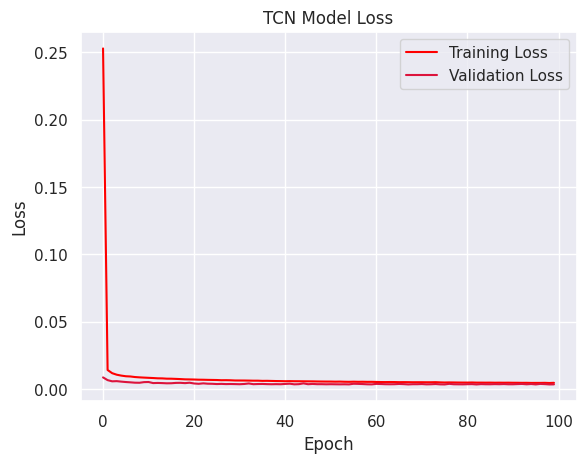

In [107]:
# summarize history for loss
plt.plot(TCN_history.history['loss'], color='red')
plt.plot(TCN_history.history['val_loss'], color='crimson')
plt.title('TCN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.savefig("training_loss.png", dpi=600)
plt.show()

In [108]:
from tensorflow.keras.models import load_model
tcn_model = load_model('/content/models/model_tcn_baseline/')


In [109]:
# Evaluate the model on the validation set
tcn_evaluation = tcn_model.evaluate(X_val, y_val)
print(f'Validation Loss: {tcn_evaluation}')

124/124 [==============================] - 2s 9ms/step - loss: 0.0034
Validation Loss: 0.003436372149735689


In [110]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# Make predictions
y_pred_train = tcn_model.predict(X_train)
y_pred_val = tcn_model.predict(X_val)
y_pred_test = tcn_model.predict(X_test)

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse
# Calculate metrics for each dataset
mae_train, mse_train, rmse_train = calculate_metrics(y_train, y_pred_train)
mae_val, mse_val, rmse_val = calculate_metrics(y_val, y_pred_val)
mae_test, mse_test, rmse_test = calculate_metrics(y_test, y_pred_test)

# Print metrics
print(f'Training - MAE: {mae_train}, MSE: {mse_train}, RMSE: {rmse_train}')
print(f'Validation - MAE: {mae_val}, MSE: {mse_val}, RMSE: {rmse_val}')
print(f'Test - MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}')

# Function to plot series
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.figure(figsize=(15, 5))
    plt.plot(time[start:end], series_true[start:end], format, label='Actual')
    plt.plot(time[start:end], series_pred[start:end], format, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



239/239 [==============================] - 2s 9ms/step
Training - MAE: 0.04043191854143277, MSE: 0.004048878834303506, RMSE: 0.06363080098744245
Validation - MAE: 0.03909873010284542, MSE: 0.0034363727827287196, RMSE: 0.0586205832684111
Test - MAE: 0.0445792656480382, MSE: 0.004525835076758278, RMSE: 0.06727432702568104


In [111]:
# Assuming we have a scaler (sc_test) and the test dataset (test_data)
# Inverse transform the predictions and actual values
num_of_feature = X_train.shape[2]  # Assuming this is the correct number of features

def inverse_transform_predictions(predictions, scaler, feature_index):
    # Reshape predictions to 2D if it is 1D
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    repeated_predictions = np.repeat(predictions, num_of_feature, axis=1)
    inverse_predictions = scaler.inverse_transform(repeated_predictions)
    return inverse_predictions[:, feature_index]

In [112]:
# Inverse transform
tcn_Y_pred = inverse_transform_predictions(y_pred_test, sc_test, 7)
tcn_actual_Y_test = inverse_transform_predictions(y_test, sc_test, 7)

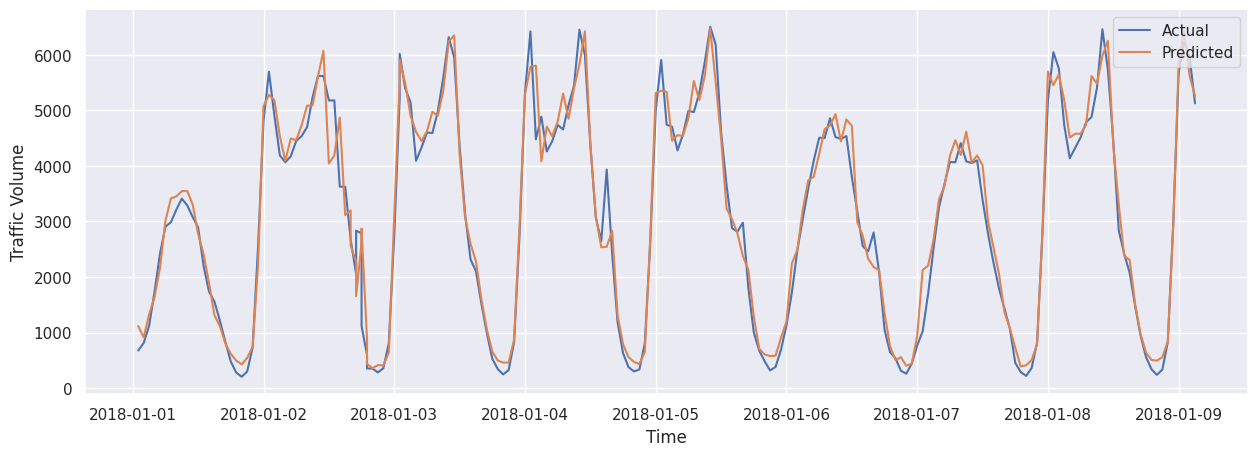

In [113]:
# Plotting the Predicted vs Actual for a subset of the test data
time_test = np.array(test_data['ds'])  # Ensure this is the time data for the test set
plot_series(time_test[:200], tcn_actual_Y_test[:200], tcn_Y_pred[:200])


In [114]:
# Creating a DataFrame for hourly predictions
data = {
    'date': time_test[:2000],
    'predictions': tcn_Y_pred[:2000],
    'actual': tcn_actual_Y_test[:2000]
}
df_tcn = pd.DataFrame(data)

# Saving the DataFrame
df_tcn.to_csv('/content/models/tcn_predictions2.csv', index=False)

In [115]:
df_tcn

,date,predictions,actual
0,2018-01-01 01:00:00,1116.136963,677.0
1,2018-01-01 02:00:00,913.009705,811.0
2,2018-01-01 03:00:00,1326.550415,1122.0
3,2018-01-01 04:00:00,1639.604004,1738.0
4,2018-01-01 05:00:00,2166.118408,2421.0
...,...,...,...
1995,2018-03-11 12:00:00,4249.757324,4068.0
1996,2018-03-11 13:00:00,4026.353271,3571.0
1997,2018-03-11 14:00:00,3530.788330,2939.0
1998,2018-03-11 15:00:00,2855.652344,2939.0


In [116]:
# Function to plot series
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.figure(figsize=(15, 5))
    plt.plot(time[start:end], series_true[start:end], format, label='Actual')
    plt.plot(time[start:end], series_pred[start:end], format, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [117]:
# Convert predictions and actual values to numpy arrays
tcn_y_pred = np.array(tcn_Y_pred)
y_true = np.array(tcn_actual_Y_test)

# Extract time data for the test set
time_test = np.array(test_data['ds'])

In [118]:
df_tcn# Define the number of data points for the hourly predictions dataframe
split = 200

# Create a dictionary containing date, predicted values, and actual values for hourly predictions
data = {
    'date': time_test[:split],
    'predictions': tcn_Y_pred[:split],
    'actual': tcn_actual_Y_test[:split]
}

# Convert the dictionary to a Pandas DataFrame
df_tcn = pd.DataFrame(data)

In [119]:
# Define a function to plot time series data with subplot
def plot_series_subplot(time, series_true, series_pred, title="", format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    plt.plot(time[start:end], series_true[start:end], format)
    plt.plot(time[start:end], series_pred[start:end], format)
    plt.xlabel('Time')
    plt.title(title)
    plt.legend(['Actual', 'Predicted'], loc='best')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

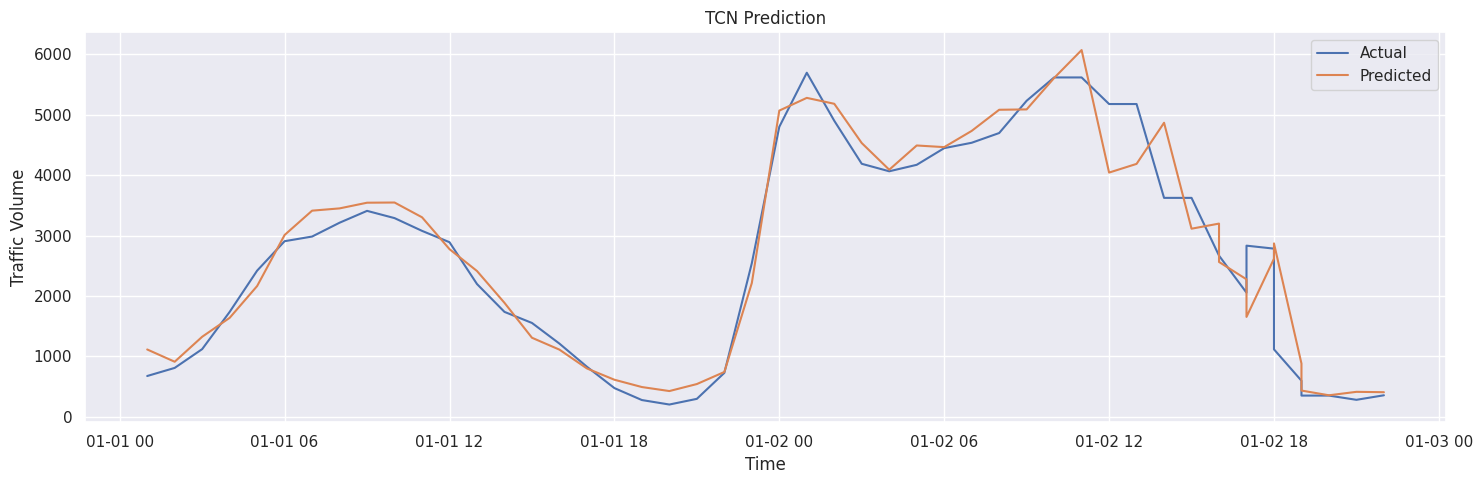

In [120]:
# Plot the actual vs predicted values for a subset of the test set with subplot
plt.figure(figsize=(15, 5))
plot_series_subplot(time_test[:50], y_true[:50], tcn_y_pred[:50], "TCN Prediction")
plt.tight_layout()
plt.savefig("prediction_0.png", dpi=600)

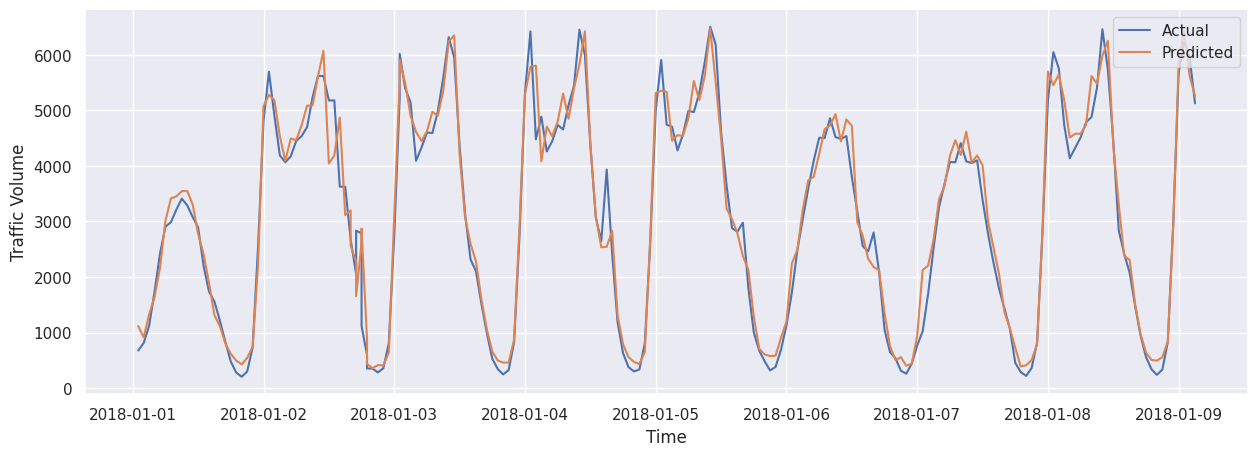

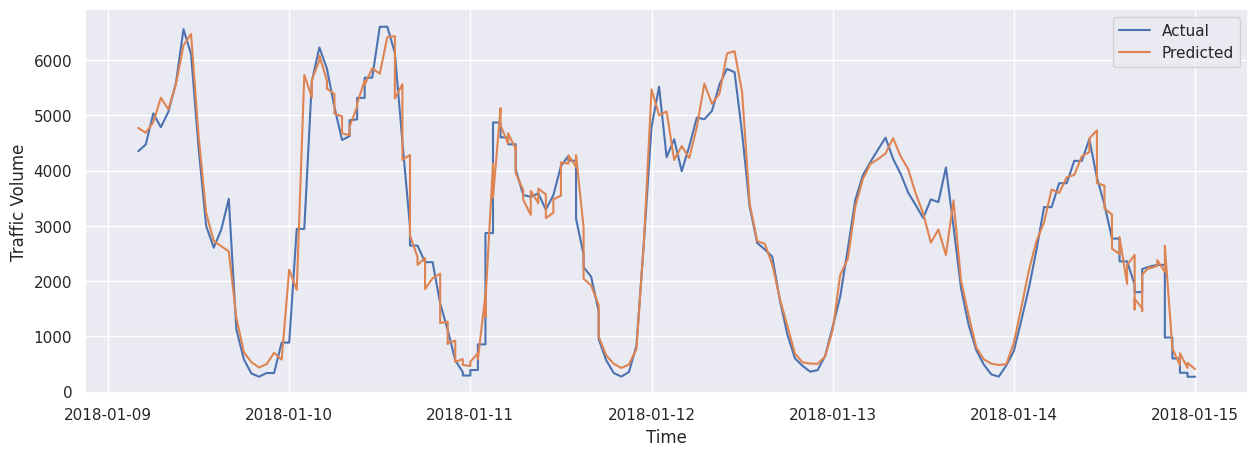

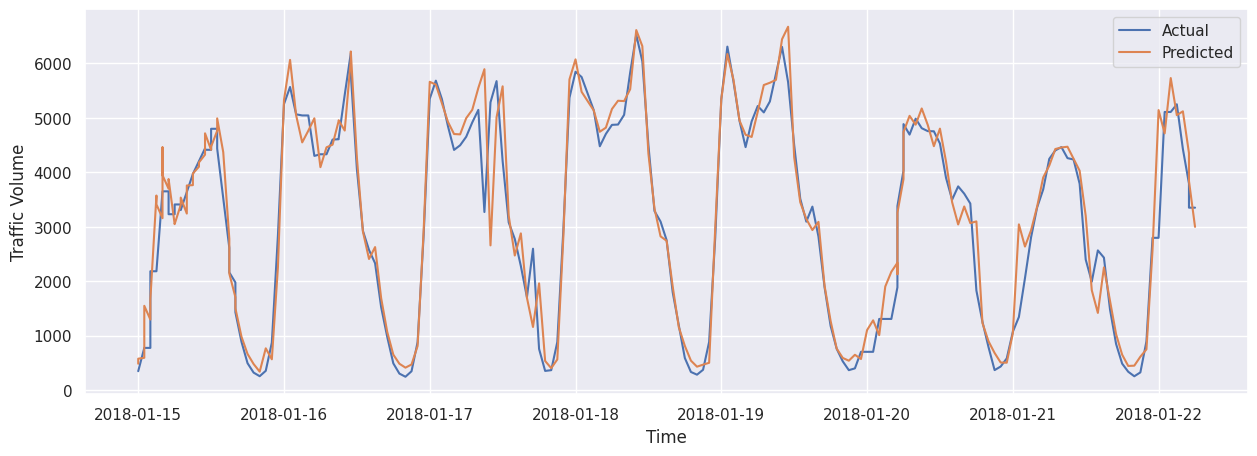

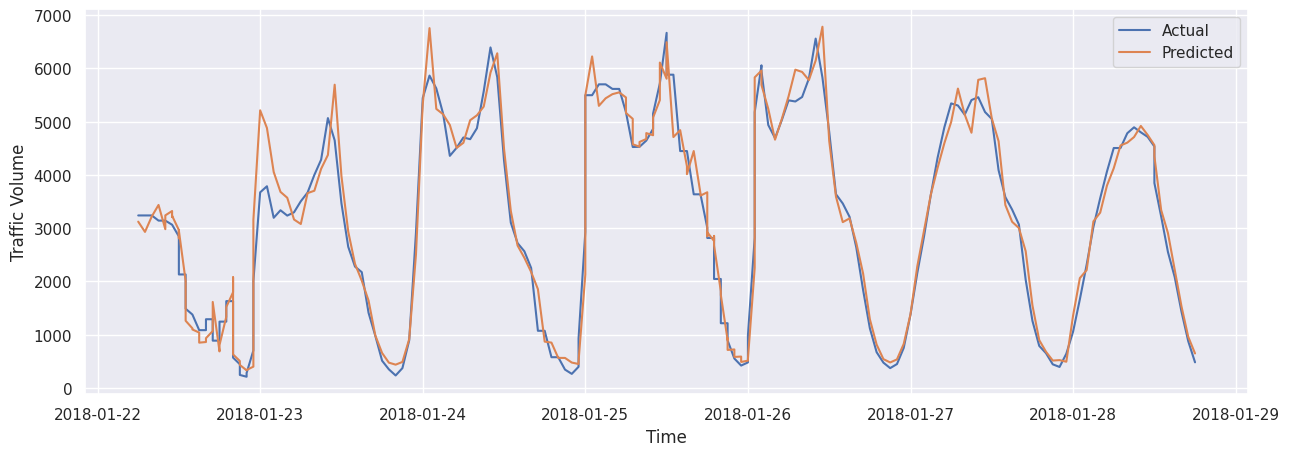

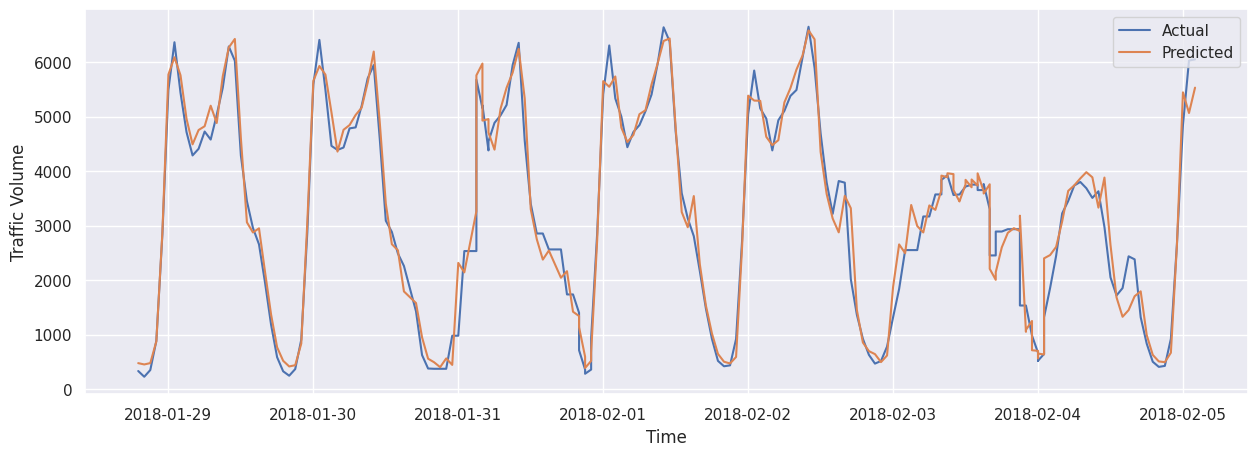

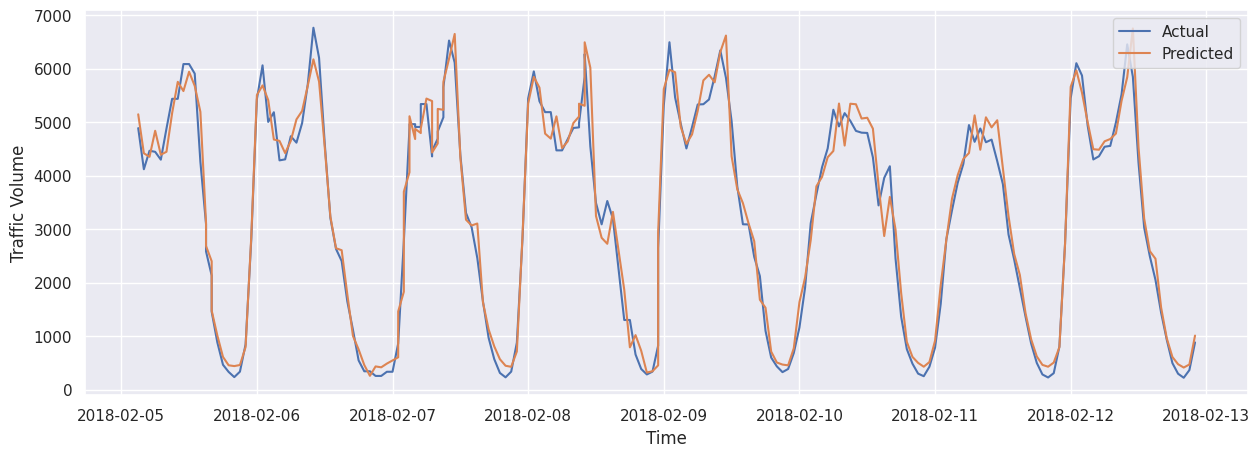

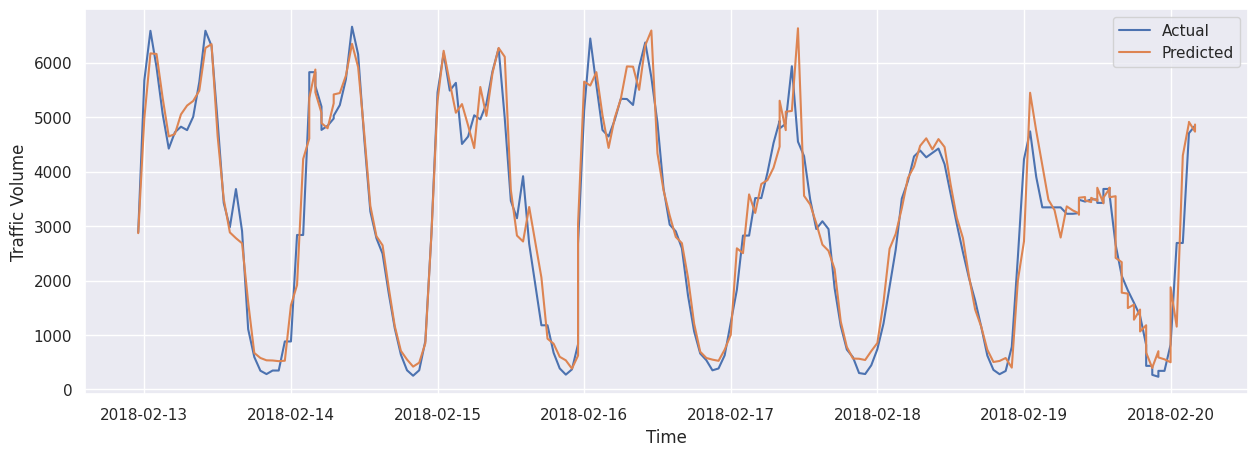

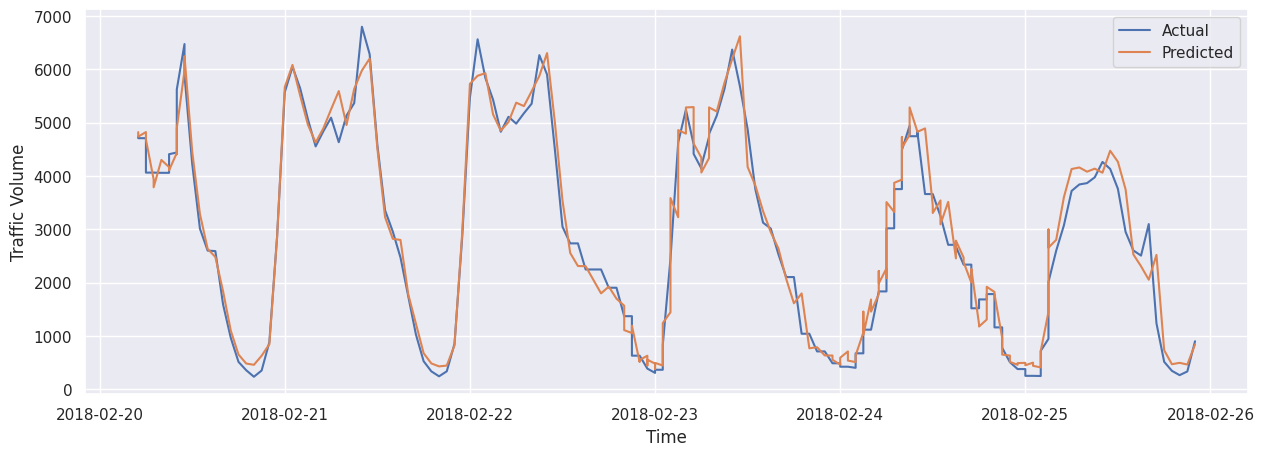

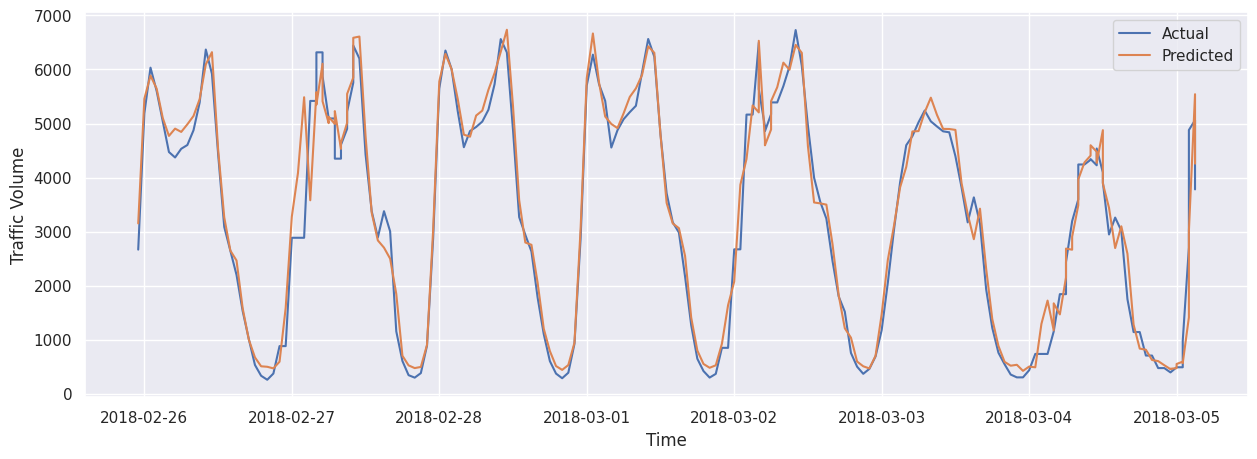

In [121]:
# Additional code for more plots across different times
for i in range(0, 1800, 200):  # 200 time steps per plot
    plot_series(time_test[i:i+200], tcn_actual_Y_test[i:i+200], tcn_Y_pred[i:i+200])